<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Se consumirán los datos de todos los productos del supermercado La Gallega.

In [ ]:
dfProductos = pd.read_json('datosLaGallega.json', orient='records')
dfProductos.head()

,descripcion,precio,linkFoto
0,rocio vegetal mazola x 120 ml. manteca,363.35,https://www.lagallega.com.ar/Archivos/Articulo...
1,rocio vegetal natura x 120 ml.,363.64,https://www.lagallega.com.ar/Archivos/Articulo...
2,rocio vegetal mazola x 120 ml. original,376.65,https://www.lagallega.com.ar/Archivos/Articulo...
3,rocio vegetal de girasol lira x 120 gr.,382.70,https://www.lagallega.com.ar/Archivos/Articulo...
4,rocio vegetal fritolim x 120 ml. clasico,394.34,https://www.lagallega.com.ar/Archivos/Articulo...


In [ ]:
print("Cantidad de documentos:", dfProductos.shape[0])

Cantidad de documentos: 4983


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [ ]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [ ]:
import random

In [ ]:
# Ejemplo de como transformar una oración a tokens usando keras
random_num = random.randint(1, dfProductos.shape[0])
text = dfProductos.iloc[random_num, 0]
text

'vino tinto esperado cabernet sauvignon x 750 ml.'

In [ ]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['vino', 'tinto', 'esperado', 'cabernet', 'sauvignon', 'x', '750', 'ml']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [ ]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in dfProductos[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['rocio', 'vegetal', 'mazola', 'x', '120', 'ml', 'manteca'],
 ['rocio', 'vegetal', 'natura', 'x', '120', 'ml']]

In [ ]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['vino', 'tinto', 'esperado', 'cabernet'],
 ['tinto', 'esperado', 'cabernet', 'sauvignon'],
 ['esperado', 'cabernet', 'sauvignon', 'x'],
 ['cabernet', 'sauvignon', 'x', '750']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[6, 4, 2, 1], [4, 2, 1, 3], [2, 1, 3, 5], [1, 3, 5, 7]]

In [ ]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

4


In [ ]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

7


In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'cabernet': 1, 'esperado': 2, 'sauvignon': 3, 'tinto': 4, 'x': 5, 'vino': 6, '750': 7}


In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'cabernet': 4, 'esperado': 3, 'tinto': 2, 'vino': 1, 'sauvignon': 3, 'x': 2, '750': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [ ]:
# Vistazo a las primeras filas
dfProductos.iloc[:15,0]

0       rocio vegetal mazola x 120 ml. manteca
1               rocio vegetal natura x 120 ml.
2      rocio vegetal mazola x 120 ml. original
3      rocio vegetal de girasol lira x 120 gr.
4     rocio vegetal fritolim x 120 ml. clasico
5         rocio vegetal natura x 120 ml. oliva
6              aceite de soja sojola x 900 ml.
7                aceite de soja sojola x1.5lt.
8         aceite de girasol legitimo x 1,5 lt.
9             aceite de girasol lira x 900 ml.
10     aceite copisi x 900 ml. girasol y oliva
11     aceite natura x 900 ml. girasol y oliva
12        aceite de girasol familiar x 1,5 lt.
13            aceite de girasol lira x 1,5 lt.
14              aceite de maiz arcor x 890 ml.
Name: descripcion, dtype: object

In [ ]:
# Concatenamos todos los rows en un solo valor
corpus = dfProductos.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'rocio vegetal mazola x 120 ml. manteca rocio vegetal natura x 120 ml. rocio vegetal mazola x 120 ml. original rocio vegetal de girasol lira x 120 gr. rocio vegetal fritolim x 120 ml. clasico rocio vegetal natura x 120 ml. oliva aceite de soja sojola x 900 ml. aceite de soja sojola x1.5lt. aceite de girasol legitimo x 1,5 lt. aceite de girasol lira x 900 ml. aceite copisi x 900 ml. girasol y oliva aceite natura x 900 ml. girasol y oliva aceite de girasol familiar x 1,5 lt. aceite de girasol lira x 1,5 lt. aceite de maiz arcor x 890 ml. aceite de oliva morixe x 500 ml. aceite de oliva mazola x 500 ml. aceite de oliva extra virgen cocinero x 500 ml. suave aceite de oliva natura x 500 ml. intenso aceite de oliva cocinero puro x 500 ml. aceite de oliva extra virgen lira x 500 ml. aceite de oliva terranova extra virgen x 500 ml. aceite de oliva extra virgen cocinero x 500 ml. aceite de oliva suave casalta x 250 ml. aceite de oliva medio casalta x 250 ml. aceite de oliva natura x 500 cc. int

In [ ]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['rocio',
 'vegetal',
 'mazola',
 'x',
 '120',
 'ml',
 'manteca',
 'rocio',
 'vegetal',
 'natura',
 'x',
 '120',
 'ml',
 'rocio',
 'vegetal',
 'mazola',
 'x',
 '120',
 'ml',
 'original']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 37288


In [ ]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['rocio', 'vegetal', 'mazola', 'x'],
 ['vegetal', 'mazola', 'x', '120'],
 ['mazola', 'x', '120', 'ml'],
 ['x', '120', 'ml', 'manteca'],
 ['120', 'ml', 'manteca', 'rocio'],
 ['ml', 'manteca', 'rocio', 'vegetal'],
 ['manteca', 'rocio', 'vegetal', 'natura'],
 ['rocio', 'vegetal', 'natura', 'x'],
 ['vegetal', 'natura', 'x', '120'],
 ['natura', 'x', '120', 'ml'],
 ['x', '120', 'ml', 'rocio'],
 ['120', 'ml', 'rocio', 'vegetal'],
 ['ml', 'rocio', 'vegetal', 'mazola'],
 ['rocio', 'vegetal', 'mazola', 'x'],
 ['vegetal', 'mazola', 'x', '120'],
 ['mazola', 'x', '120', 'ml'],
 ['x', '120', 'ml', 'original'],
 ['120', 'ml', 'original', 'rocio'],
 ['ml', 'original', 'rocio', 'vegetal'],
 ['original', 'rocio', 'vegetal', 'de']]

In [ ]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[733, 500, 1658, 1],
 [500, 1658, 1, 65],
 [1658, 1, 65, 3],
 [1, 65, 3, 196],
 [65, 3, 196, 733],
 [3, 196, 733, 500],
 [196, 733, 500, 429],
 [733, 500, 429, 1],
 [500, 429, 1, 65],
 [429, 1, 65, 3],
 [1, 65, 3, 733],
 [65, 3, 733, 500],
 [3, 733, 500, 1658],
 [733, 500, 1658, 1],
 [500, 1658, 1, 65],
 [1658, 1, 65, 3],
 [1, 65, 3, 91],
 [65, 3, 91, 733],
 [3, 91, 733, 500],
 [91, 733, 500, 4]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 37284


### 3 - Input y target

In [ ]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(37284, 3)
(37284,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'x',
 2: 'gr',
 3: 'ml',
 4: 'de',
 5: 'unid',
 6: '1',
 7: 'la',
 8: '750',
 9: '500',
 10: '100',
 11: 'vino',
 12: 'lt',
 13: 'en',
 14: 'leche',
 15: 'queso',
 16: 'con',
 17: '200',
 18: 'y',
 19: '400',
 20: 'para',
 21: 'crema',
 22: 'polvo',
 23: '2',
 24: '250',
 25: 'tinto',
 26: 'jabon',
 27: '3',
 28: 'chocolate',
 29: 'kg',
 30: '300',
 31: 'dulce',
 32: 'light',
 33: 'p',
 34: 'yogur',
 35: 'sin',
 36: '5',
 37: 'blanco',
 38: '25',
 39: 'galletitas',
 40: 'cerveza',
 41: 'vainilla',
 42: '50',
 43: 'shampoo',
 44: '6',
 45: 'cafe',
 46: 'x100gr',
 47: 'acondicionador',
 48: '4',
 49: 'paladini',
 50: 'limpiador',
 51: 'mate',
 52: 'frutilla',
 53: '150',
 54: 'serenisima',
 55: 'sabor',
 56: 'jugo',
 57: 'liquido',
 58: 'saquitos',
 59: 'dental',
 60: 'toallas',
 61: 'naranja',
 62: 'malbec',
 63: 'cabernet',
 64: 'sal',
 65: '120',
 66: 'yerba',
 67: 'del',
 68: '180',
 69: 'desodorante',
 70: 'clasico',
 71: 'c',
 72: 'suave',
 73: 'te',
 74: '8',
 75: 'sauvignon',

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3367

In [ ]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(37284, 3367)

### 4 - Entrenar el modelo

In [ ]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [ ]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3367

# Modelo 1 output dim

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=8, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 8)              26944     
                                                                 
 lstm_4 (LSTM)               (None, 3, 64)             18688     
                                                                 
 dropout_2 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3367)              111111    
                                                                 
Total params: 191847 (749.40 KB)
Trainable params: 191

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
933/933 [==============================] - 8s 9ms/step - loss: 1.9076 - accuracy: 0.5256 - val_loss: 25.3719 - val_accuracy: 0.1312
Epoch 2/50
933/933 [==============================] - 8s 9ms/step - loss: 1.8904 - accuracy: 0.5229 - val_loss: 25.4345 - val_accuracy: 0.1320
Epoch 3/50
933/933 [==============================] - 8s 9ms/step - loss: 1.8831 - accuracy: 0.5293 - val_loss: 25.9521 - val_accuracy: 0.1345
Epoch 4/50
933/933 [==============================] - 8s 8ms/step - loss: 1.8657 - accuracy: 0.5319 - val_loss: 25.8974 - val_accuracy: 0.1326
Epoch 5/50
933/933 [==============================] - 8s 9ms/step - loss: 1.8553 - accuracy: 0.5324 - val_loss: 26.1405 - val_accuracy: 0.1312
Epoch 6/50
933/933 [==============================] - 9s 9ms/step - loss: 1.8430 - accuracy: 0.5353 - val_loss: 26.2253 - val_accuracy: 0.1336
Epoch 7/50
933/933 [==============================] - 10s 10ms/step - loss: 1.8302 - accuracy: 0.5361 - val_loss: 26.2034 - val_accuracy: 0.13

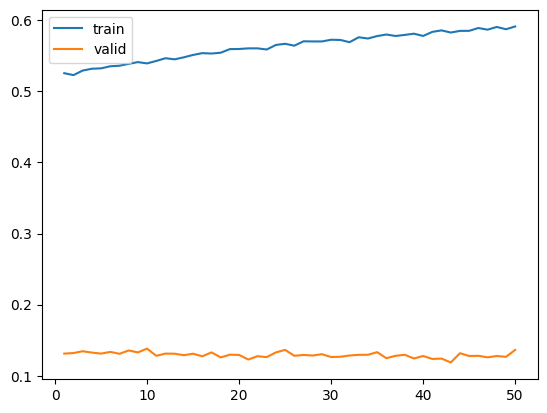

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

# Modelo 2 output dim 4

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=4, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 4)              13472     
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             17664     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3367)              111111    
                                                                 
Total params: 177351 (692.78 KB)
Trainable params: 177

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
933/933 [==============================] - 17s 15ms/step - loss: 6.2003 - accuracy: 0.1230 - val_loss: 7.6901 - val_accuracy: 0.1110
Epoch 2/50
933/933 [==============================] - 10s 11ms/step - loss: 5.7731 - accuracy: 0.1337 - val_loss: 7.7797 - val_accuracy: 0.1318
Epoch 3/50
933/933 [==============================] - 8s 9ms/step - loss: 5.1463 - accuracy: 0.2061 - val_loss: 8.0352 - val_accuracy: 0.1525
Epoch 4/50
933/933 [==============================] - 7s 8ms/step - loss: 4.7571 - accuracy: 0.2434 - val_loss: 8.3721 - val_accuracy: 0.1558
Epoch 5/50
933/933 [==============================] - 8s 9ms/step - loss: 4.5161 - accuracy: 0.2627 - val_loss: 9.2644 - val_accuracy: 0.1573
Epoch 6/50
933/933 [==============================] - 9s 10ms/step - loss: 4.3113 - accuracy: 0.2801 - val_loss: 9.7738 - val_accuracy: 0.1637
Epoch 7/50
933/933 [==============================] - 8s 8ms/step - loss: 4.1240 - accuracy: 0.2899 - val_loss: 10.5362 - val_accuracy: 0.1592


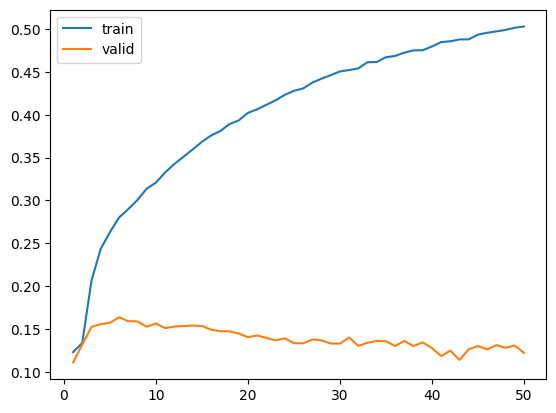

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

# iface = gr.Interface(
#     fn=model_response,
#     inputs=["textbox"],
#     outputs="text",
#     layout="vertical")

# iface.launch(debug=True)

In [ ]:
model_response('crema de')

1/1 [==============================] - 0s 20ms/step


'crema de prolongada'

In [ ]:
model_response('shamnpoo')

1/1 [==============================] - 0s 18ms/step


'shamnpoo '

In [ ]:
model_response('salsa de')

1/1 [==============================] - 0s 28ms/step


'salsa de comunes'

In [ ]:
model_response('gaseosa de')

1/1 [==============================] - 0s 44ms/step


'gaseosa de manana'

### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='leche entera'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 16ms/step


'leche entera 1 virgin'

In [ ]:
input_text='harina con'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 16ms/step


'harina con granby pizzas'

In [ ]:
input_text='gaseosa de'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 36ms/step


'gaseosa de manana ml'

### 7 - Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  # idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="alfajor triple")

1/1 [==============================] - 0s 19ms/step


In [ ]:
# veamos las salidas
decode(salidas[0])

['alfajor triple 1 virgin suflair margarina']

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="salsa de")

1/1 [==============================] - 0s 20ms/step


In [ ]:
# veamos las salidas
decode(salidas[0])

['salsa de comunes balsamico fuyi life']

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="cafe en")

1/1 [==============================] - 0s 17ms/step


In [ ]:
# veamos las salidas
decode(salidas[0])

['cafe en esponja desodorante dos dos dos dos']

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="dulce de")

1/1 [==============================] - 0s 17ms/step


In [ ]:
# veamos las salidas
decode(salidas[0])

['dulce de en 1 menta changlot']

### 8 - Conclusiones
Se ha probado dos modelos con diferentes `outputdim` del embedding igual a 4 e igual a 8 como la raiz cuarta del vocabulario.
El modelo entrenado tuvo un mal desempeño en el entrenamiento. No obstante empezo a entrenar bien, pero luego diverge con dim 4.
 Cuestiones que podrían mejorarse:
- Mejorar el corpus
- Filtrar numeros y sibolos de unidades
- Probar otros modelos

Considerando que el dataset son descripciones de productos de supermercado, se trato de buscar la predicción de la palabra siguiente en base a dichos productos. Como la mayoria son productos especificos tal vez tenga una mayor importancia la calidad del dato y no el modelo en si.